# Face Recognition

## Installing LIbraries and setting GPU limit

In [ ]:
!pip install -q tensorflow opencv-python matplotlib

In [ ]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import uuid

In [ ]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Folder Structure

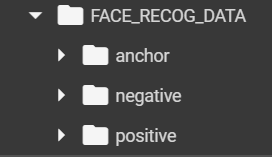

In [ ]:
PATH = '/content/drive/MyDrive/FACE_RECOG_DATA'
ANC_PATH = os.path.join(PATH, 'anchor')
POS_PATH = os.path.join(PATH, 'positive')
NEG_PATH = os.path.join(PATH, 'negative')

In [ ]:
# lfw dataset is in the negative folder after extraction
# !unzip /content/drive/MyDrive/LS_ML_24.zip -d /content/drive/MyDrive/

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/FACE_RECOG_DATA/negative/Mark_Martin_0001.jpg  
  inflating: /content/drive/MyDrive/FACE_RECOG_DATA/negative/Mark_McClellan_0001.jpg  
  inflating: /content/drive/MyDrive/FACE_RECOG_DATA/negative/Mark_Mishkin_0001.jpg  
  inflating: /content/drive/MyDrive/FACE_RECOG_DATA/negative/Mark_Mulder_0001.jpg  
  inflating: /content/drive/MyDrive/FACE_RECOG_DATA/negative/Mark_Philippoussis_0001.jpg  
  inflating: /content/drive/MyDrive/FACE_RECOG_DATA/negative/Mark_Philippoussis_0002.jpg  
  inflating: /content/drive/MyDrive/FACE_RECOG_DATA/negative/Mark_Philippoussis_0003.jpg  
  inflating: /content/drive/MyDrive/FACE_RECOG_DATA/negative/Mark_Philippoussis_0004.jpg  
  inflating: /content/drive/MyDrive/FACE_RECOG_DATA/negative/Mark_Philippoussis_0005.jpg  
  inflating: /content/drive/MyDrive/FACE_RECOG_DATA/negative/Mark_Philippoussis_0006.jpg  
  inflating: /content/drive/MyDrive/FACE_RECOG_DATA/negative/Ma

## Data Augmentation

In [ ]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))

        data.append(img)

    return data

In [ ]:
# in positive dataset
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)

    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
# in anchor daatset
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)

    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
!ls -l /content/drive/MyDrive/FACE_RECOG_DATA/anchor | wc -l
!ls -l /content/drive/MyDrive/FACE_RECOG_DATA/positive | wc -l
!ls -l /content/drive/MyDrive/FACE_RECOG_DATA/negative | wc -l

4851
3221
13234


## Load and Preprocess Images

In [ ]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(3000)

In [ ]:
dir_test = anchor.as_numpy_iterator()

In [ ]:
print(dir_test.next())

b'/content/drive/MyDrive/FACE_RECOG_DATA/anchor/db9030c6-4f2a-11ef-a1a5-0242ac1c000c.jpg'


In [ ]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image
    return img

In [ ]:
# (anchor, positive) => 1
# (anchor, negative) => 0

In [ ]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [ ]:
samples = data.as_numpy_iterator()

In [ ]:
ex = samples.next()

In [ ]:
ex

(b'/content/drive/MyDrive/FACE_RECOG_DATA/anchor/fe0fe3ee-4f2a-11ef-a1a5-0242ac1c000c.jpg',
 b'/content/drive/MyDrive/FACE_RECOG_DATA/positive/c2b50a9a-4f2a-11ef-a1a5-0242ac1c000c.jpg',
 1.0)

In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
res = preprocess_twin(*ex)

In [ ]:
plt.imshow(res[1])

In [ ]:
res[2]

1.0

In [ ]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [ ]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## Model Engineering

In [ ]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [ ]:
# Siamese L1 Distance class
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [ ]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    # Outputs between 0 to 1 indicating wheather two images are same or not
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [ ]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

## Training

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [ ]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

In [ ]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object
        r = Recall()
        p = Precision()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
train(train_data, 50)

Streaming output truncated to the last 5000 lines.
263/263 [==============================] - 62s 234ms/step
0.1299823 0.998076 0.99282295

 Epoch 33/50
263/263 [==============================] - 61s 231ms/step
0.002209363 0.9985598 0.9990394

 Epoch 34/50
263/263 [==============================] - 61s 230ms/step
0.08209495 0.99952036 0.99952036

 Epoch 35/50
263/263 [==============================] - 61s 233ms/step
2.3618393e-06 0.99569994 0.9914367

 Epoch 36/50
263/263 [==============================] - 62s 235ms/step
0.038543563 0.99855214 0.9894787

 Epoch 37/50
263/263 [==============================] - 61s 233ms/step
8.1956455e-07 1.0 0.9952471

 Epoch 38/50
263/263 [==============================] - 62s 236ms/step
0.022795934 0.99952036 0.99952036

 Epoch 39/50
263/263 [==============================] - 62s 234ms/step
0.03628024 1.0 0.99384177

 Epoch 40/50
263/263 [==============================] - 61s 233ms/step
0.0011779591 0.9995272 0.9995272

 Epoch 41/50
263/263 [========

## Evaluation

In [ ]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 26ms/step


In [ ]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1]

In [ ]:
y_true

array([1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [ ]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [ ]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [ ]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat)

print("Recall: ", r.result().numpy())
print("Precision: ", p.result().numpy())

1/1 [==============================] - 0s 22ms/step
Recall:  0.9978518
Precision:  1.0


In [ ]:
# Save weights
siamese_model.save(os.path.join(PATH, 'siamesemodelv2.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Reload model
siamese_model = tf.keras.models.load_model(os.path.join(PATH, 'siamesemodelv2.h5'), custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 147ms/step


array([[2.7858721e-05],
       [9.5380670e-01],
       [7.4891865e-01],
       [8.1319642e-01],
       [3.7242673e-05],
       [9.0742942e-06],
       [7.5175321e-01],
       [8.9901400e-01]], dtype=float32)

## Testing

In [60]:
def face_detection(img1, img2):
  preprocessed_image1 = preprocess(img1)
  preprocessed_image2 = preprocess(img2)
  plt.figure(figsize=(10,8))
  plt.subplot(1,2,1)
  plt.imshow(preprocessed_image1)
  plt.subplot(1,2,2)
  plt.imshow(preprocessed_image2)
  plt.show()
  result = siamese_model.predict(list(np.expand_dims([preprocessed_image1, preprocessed_image2], axis=1)))
  print(result)
  if result > 0.5:
    print("Matched")
  else:
    print("Not Matched")

In [ ]:
# this part is in the video
while(1):
  img1 = input("Enter the path of first image: ")
  img2 = input("Enter the path of second image: ")
  if(img1 == 'q' and img2 == 'q'):
    break
  else:
    face_detection(img1, img2)